#### Описание датасета
Был выбран датасет с данными о 50 самых продаваемых книгах на Амазоне в период с 2009 по 2019 год. Этот датасет включает в себя данные, описанные в разделе ниже.\
Ссылка на датасет: `https://www.kaggle.com/datasets/sootersaalu/amazon-top-50-bestselling-books-2009-2019`\
Реальные данные для датасета автор взял с сайта Amazon.

##### Описание столбцов:

<pre>
+----------------------------------------------------------+
| Название    | Тип данных | Описание                      |
|-------------+------------+-------------------------------|
| Name        | object     | Название книги                |
| Author      | object     | Автор книги                   |
| User Rating | float64    | Пользовательская оценка книги |
| Reviews     | int64      | Количество отзывов о книге    |
| Price       | int64      | Цена книги                    |
| Year        | int64      | Год продажи книги             |
| Genre       | object     | Жанр книги                    |
+----------------------------------------------------------+
</pre>

Будем рассматривать только столбцы с числовыми типами данных `float64` и `int64`.


In [2893]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer

In [2894]:
data = pd.read_csv("./bestsellers_with_categories.csv")
data.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


#### Начало работы
В качестве метки возьмём `User Rating`, который преобразуем в атрибут `Is Good` для удобства работы.  

In [2895]:
warnings.filterwarnings("ignore")
numeric_data = data.select_dtypes(include=["int64", "float64"])
numeric_data["Is Good"] = numeric_data["User Rating"].apply(lambda rating: int(rating > 4.2))

target_column = "Is Good"
target = numeric_data[target_column]
target.dropna(inplace=True)
target.value_counts(normalize=True)

Is Good
1    0.936364
0    0.063636
Name: proportion, dtype: float64

Приведём данные к стандартному виду

In [2896]:
x = numeric_data.drop(columns=target_column)
y = numeric_data[target_column]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled

array([[ 0.35999008,  0.46045266, -0.47080975,  0.63245553],
       [-0.08097772, -0.84478593,  0.82160918, -0.9486833 ],
       [ 0.35999008,  0.59944035,  0.17539971,  1.26491106],
       ...,
       [ 0.35999008,  0.20286897, -0.47080975,  0.9486833 ],
       [ 0.35999008,  0.20286897, -0.47080975,  1.26491106],
       [ 0.35999008,  0.20286897, -0.47080975,  1.58113883]])

Получим обучающую и тестовую выборку

In [2897]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y)

Используем алгоритмы классификации `k-NN` и `Decision Tree`

In [2898]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier()

Оценим точность

In [2899]:
y_pred_knn = knn.predict(x_test)
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Accuracy:\n", accuracy_score(y_test, y_pred_knn))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.99      1.00      1.00       130

    accuracy                           0.99       138
   macro avg       1.00      0.94      0.96       138
weighted avg       0.99      0.99      0.99       138

Accuracy:
 0.9927536231884058


In [2900]:
y_pred_dt = dt.predict(x_test)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Accuracy:\n", accuracy_score(y_test, y_pred_dt))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00       130

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138

Accuracy:
 1.0


Построим `ROC` кривую

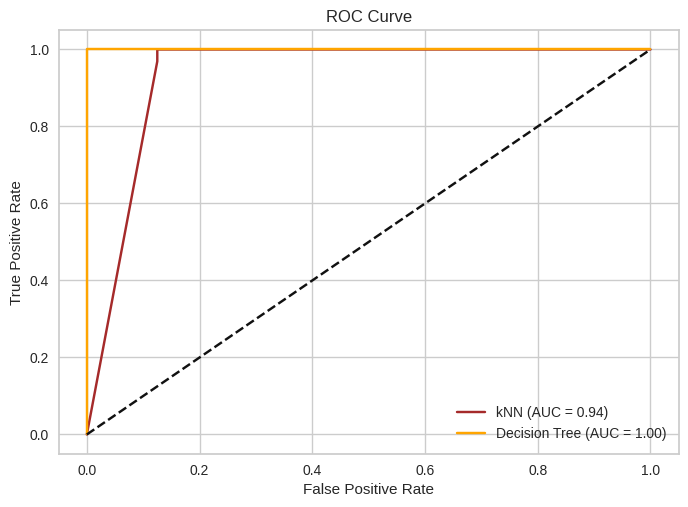

In [2901]:
y_proba_knn = knn.predict_proba(x_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
auc_knn = roc_auc_score(y_test, y_proba_knn)

plt.plot(fpr_knn, tpr_knn, label=f"kNN (AUC = {auc_knn:.2f})", color="brown")

y_proba_dt = dt.predict_proba(x_test)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})", color="orange")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Построим графики различных метрик оценки качества: `Accuracy`, `Precision`, `Recall`, `F-measure`

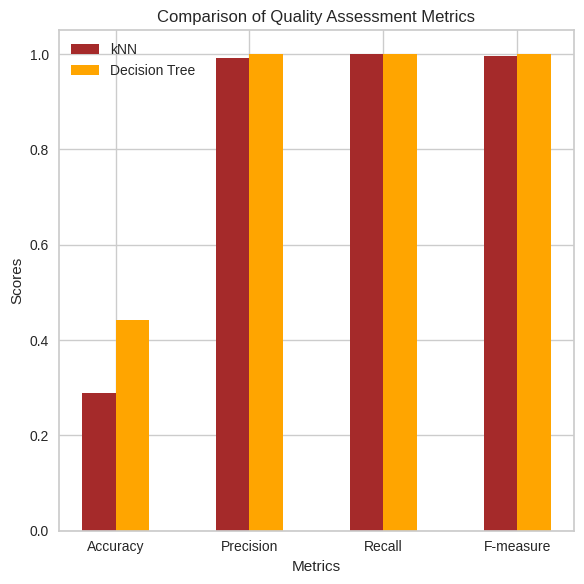

In [2902]:
cls_report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
cls_report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

res = pd.DataFrame({
    "Model": ["kNN", "Decision Tree"],
    "Accuracy": [accuracy_knn, accuracy_dt],
    "Precision": [
        cls_report["1"]["precision"]
        for cls_report in (cls_report_knn, cls_report_dt)
    ],
    "Recall": [
        cls_report["1"]["recall"]
        for cls_report in (cls_report_knn, cls_report_dt)
    ],
    "F-measure": [
        cls_report["1"]["f1-score"]
        for cls_report in (cls_report_knn, cls_report_dt)
    ],
})

metrics = ["Accuracy", "Precision", "Recall", "F-measure"]
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(x - width / 2, res.iloc[0, 1:], width, label="kNN", color="brown")
ax.bar(x + width / 2, res.iloc[1, 1:], width, label="Decision Tree", color="orange")

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Quality Assessment Metrics")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

#### Выводы
В ходе лабораторной работы были исследованы алгоритмы классификации: `kNN` и `Дерево решений`. Также были применены метрики для оценки качества классификации. Эта лабораторная работа позволила сравнить качество применения различных моделей для классов, основанных на пользовательском рейтинге. В итоге, удалось выяснить, как правильно выбирать алгоритмы классификации для различных данных.
